In [1]:
import pandas as panda

from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from scipy import stats


from matplotlib import pyplot as plot
import matplotlib.patches as mpatches

import seaborn as sns


from numpy import bincount, linspace, mean, std, arange, squeeze

import itertools, time, datetime
from collections import Counter

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
remote_location_test_data = "leaf_classification_data/test.csv"
remote_location_training_data = "leaf_classification_data/train.csv"

In [3]:
test_data = panda.read_csv(remote_location_test_data)
train_data = panda.read_csv(remote_location_training_data)

print('Testing Data Shape: ', test_data.shape, ' , Training Data Shape: ' , train_data.shape)

Testing Data Shape:  (594, 193)  , Training Data Shape:  (990, 194)




As expected, testing data has one lesser column. This is because the testing data set does not have the target column.

Lets proceed with our data analysis on the training data

Spread of unique leaf attributes in training data: 
 Cornus_Chinensis                10
Populus_Grandidentata           10
Magnolia_Heptapeta              10
Quercus_Phillyraeoides          10
Quercus_Ilex                    10
Quercus_Alnifolia               10
Viburnum_Tinus                  10
Eucalyptus_Glaucescens          10
Quercus_Coccifera               10
Alnus_Maximowiczii              10
Acer_Saccharinum                10
Populus_Nigra                   10
Quercus_Shumardii               10
Quercus_Kewensis                10
Quercus_Chrysolepis             10
Pterocarya_Stenoptera           10
Phildelphus                     10
Lithocarpus_Edulis              10
Quercus_Agrifolia               10
Quercus_Castaneifolia           10
Olea_Europaea                   10
Alnus_Cordata                   10
Cytisus_Battandieri             10
Liquidambar_Styraciflua         10
Quercus_Trojana                 10
Quercus_Dolicholepis            10
Tilia_Tomentosa                 10
Li

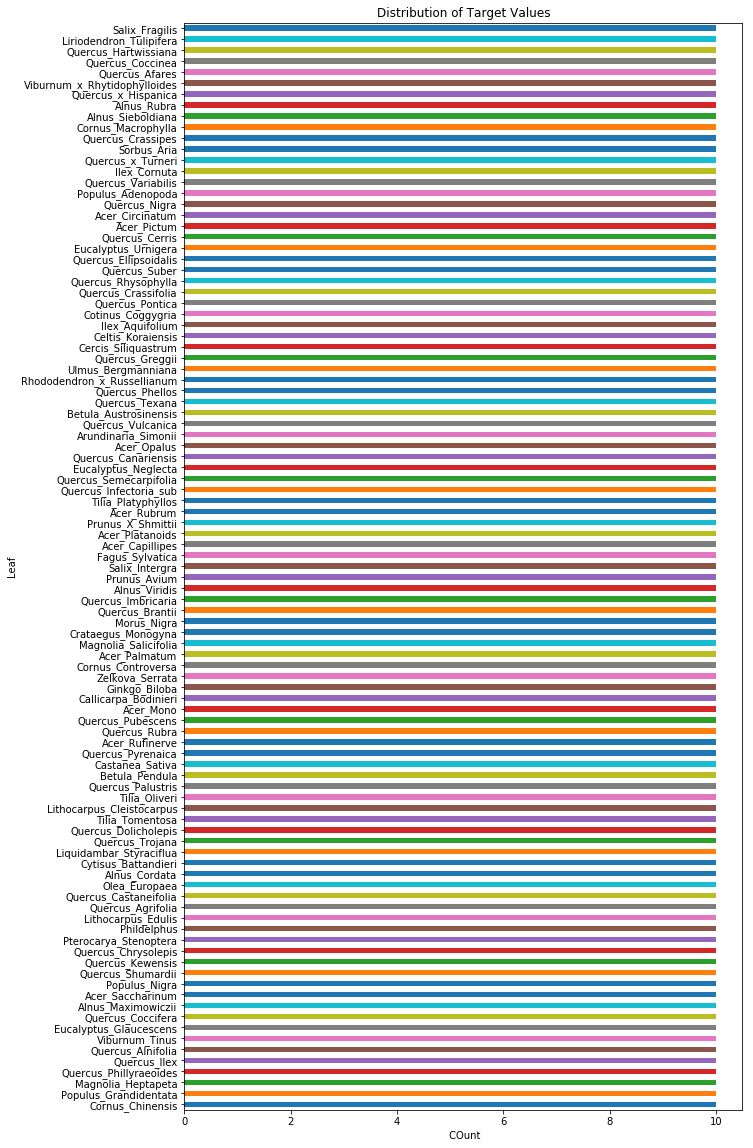

array([ 3, 49, 65, 94, 84, 40, 54, 78, 53, 89, 98, 16, 74, 50, 58, 31, 43,
        4, 75, 44, 83, 84, 13, 66, 15,  6, 73, 22, 73, 31, 36, 27, 94, 88,
       12, 28, 21, 25, 20, 60, 84, 65, 69, 58, 23, 76, 18, 52, 54,  9, 48,
       47, 64, 81, 83, 36, 58, 21, 81, 20, 62, 88, 34, 92, 79, 82, 20, 32,
        4, 84, 36, 35, 72, 60, 71, 72, 52, 50, 54, 11, 51, 18, 47,  5,  8,
       37, 97, 20, 33,  1, 59,  1, 56,  1,  9, 57, 20, 79, 29, 16, 32, 54,
       93, 10, 46, 59, 84, 76, 15, 10, 15,  0, 69,  4, 51, 51, 94, 36, 39,
       62,  2, 24, 26, 35, 25, 87,  0, 55, 34, 38,  1, 45,  7, 93, 56, 38,
       21, 51, 75, 81, 74, 33, 20, 37,  9, 40, 60, 31, 83, 50, 71, 67, 30,
       66,  1, 43, 61, 23, 65, 84, 87, 46, 57, 16,  2, 28, 12, 96, 44, 76,
       29, 75, 41, 87, 67, 61, 30,  5, 12, 62,  3, 83, 81,  6, 85,  4, 37,
       57, 84, 39, 71, 61,  6, 76, 14, 31, 98, 40, 17, 51, 16, 42, 63, 86,
       37, 69, 86, 71, 80, 78, 14, 35, 25,  5, 39,  8,  9, 26, 44, 60, 13,
       14, 77, 13, 80, 87

In [4]:
target_attribute = 'species'
target_spread = train_data[target_attribute].value_counts()

print('Spread of unique leaf attributes in training data: \n', target_spread)
train_data[target_attribute].describe(include = 'all')


target_spread.plot(kind = 'barh', figsize = (10,20))
plot.title("Distribution of Target Values")
plot.xlabel(" COunt")
plot.ylabel("Leaf")
plot.show()

encoder = LabelEncoder()
encoder.fit(train_data[target_attribute])
_y_train = encoder.transform(train_data[target_attribute])
Y = _y_train
_y_train



For our target attribute, we see a pretty even distribution of leaf species, each unique leaf is marked ten times. 

Lets check the data types of our remaining columns. And also check for empty values. 


Findings:

1. All our columns are numeric


2. All our columns contain values, none are empty of numpy.nan


3. There are some columns where values are very miniscule, ie most values are 0. eg margin8, margin 23, etc. Since it is difficult to visualize all such columns, lets divide it up by names (shapes, margins, textures) and see if we can figure out such columns where most appearances are of 0 and mean value is very less .


4. For the columns where we find that maximum number of values are 0, we will also plot the correlation coefficient and p value with the target attribute to check.



In [5]:
all_columns = train_data.columns.tolist()
columns_unwanted = ['id', 'species']
columns_wanted = [i for i in all_columns if i not in columns_unwanted]
print('Number of unique data types in the data \n', train_data[columns_wanted ].dtypes.value_counts())


empty_values = train_data[columns_wanted ].isnull().sum().to_frame()
empty_values= empty_values.assign(column_type = train_data.dtypes)
print('Number of empty columns: ', set(empty_values[0].values))


train_data_description = train_data[columns_wanted ].describe(include = "all")
train_data_description = train_data_description.transpose()[['25%', '50%', '75%', 'max', 'mean']]
train_data_description

# train_data_description.iloc[0 : 64, :]
# train_data_description.loc[['margin1', 'margin2'], ['max']]

Number of unique data types in the data 
 float64    192
dtype: int64
Number of empty columns:  {0}


,25%,50%,75%,max,mean
margin1,0.001953,0.009766,0.025391,0.087891,0.017412
margin2,0.001953,0.011719,0.041016,0.205080,0.028539
margin3,0.013672,0.025391,0.044922,0.156250,0.031988
margin4,0.005859,0.013672,0.029297,0.169920,0.023280
margin5,0.001953,0.007812,0.017578,0.111330,0.014264
margin6,0.000000,0.015625,0.056153,0.310550,0.038579
margin7,0.005859,0.015625,0.029297,0.091797,0.019202
margin8,0.000000,0.000000,0.000000,0.031250,0.001083
margin9,0.001953,0.005859,0.007812,0.076172,0.007167
margin10,0.005859,0.015625,0.027344,0.097656,0.018639


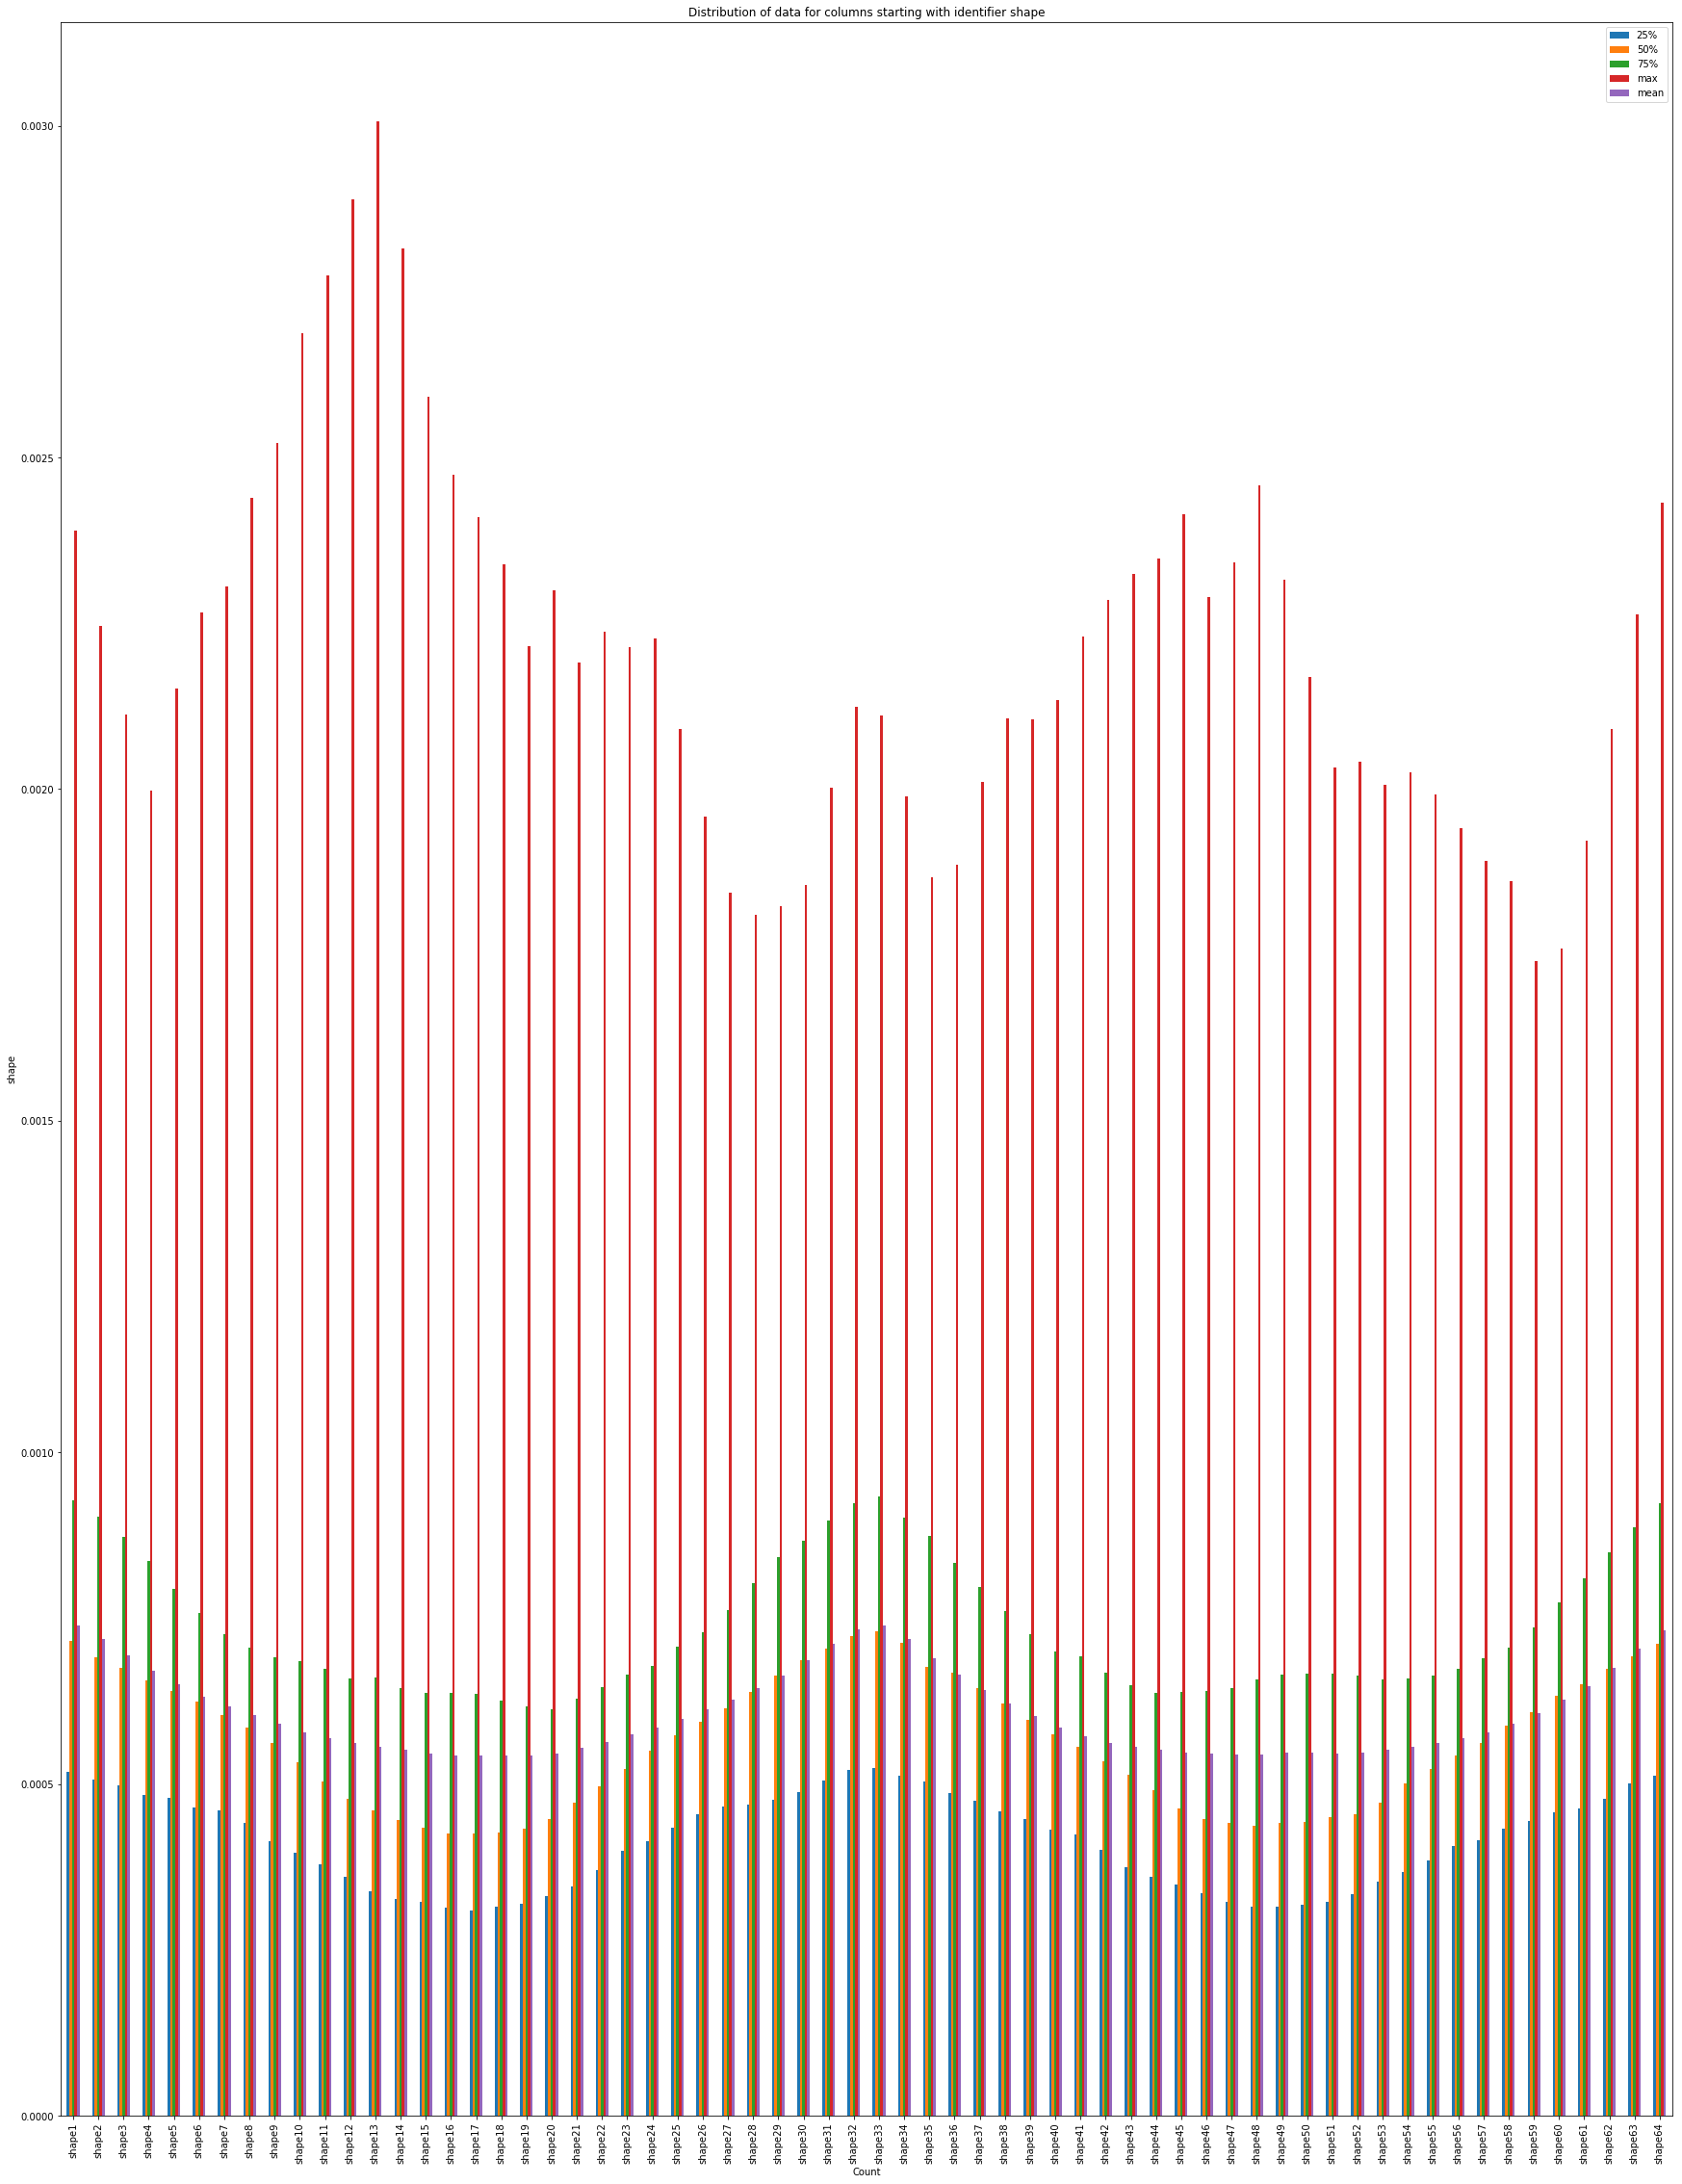

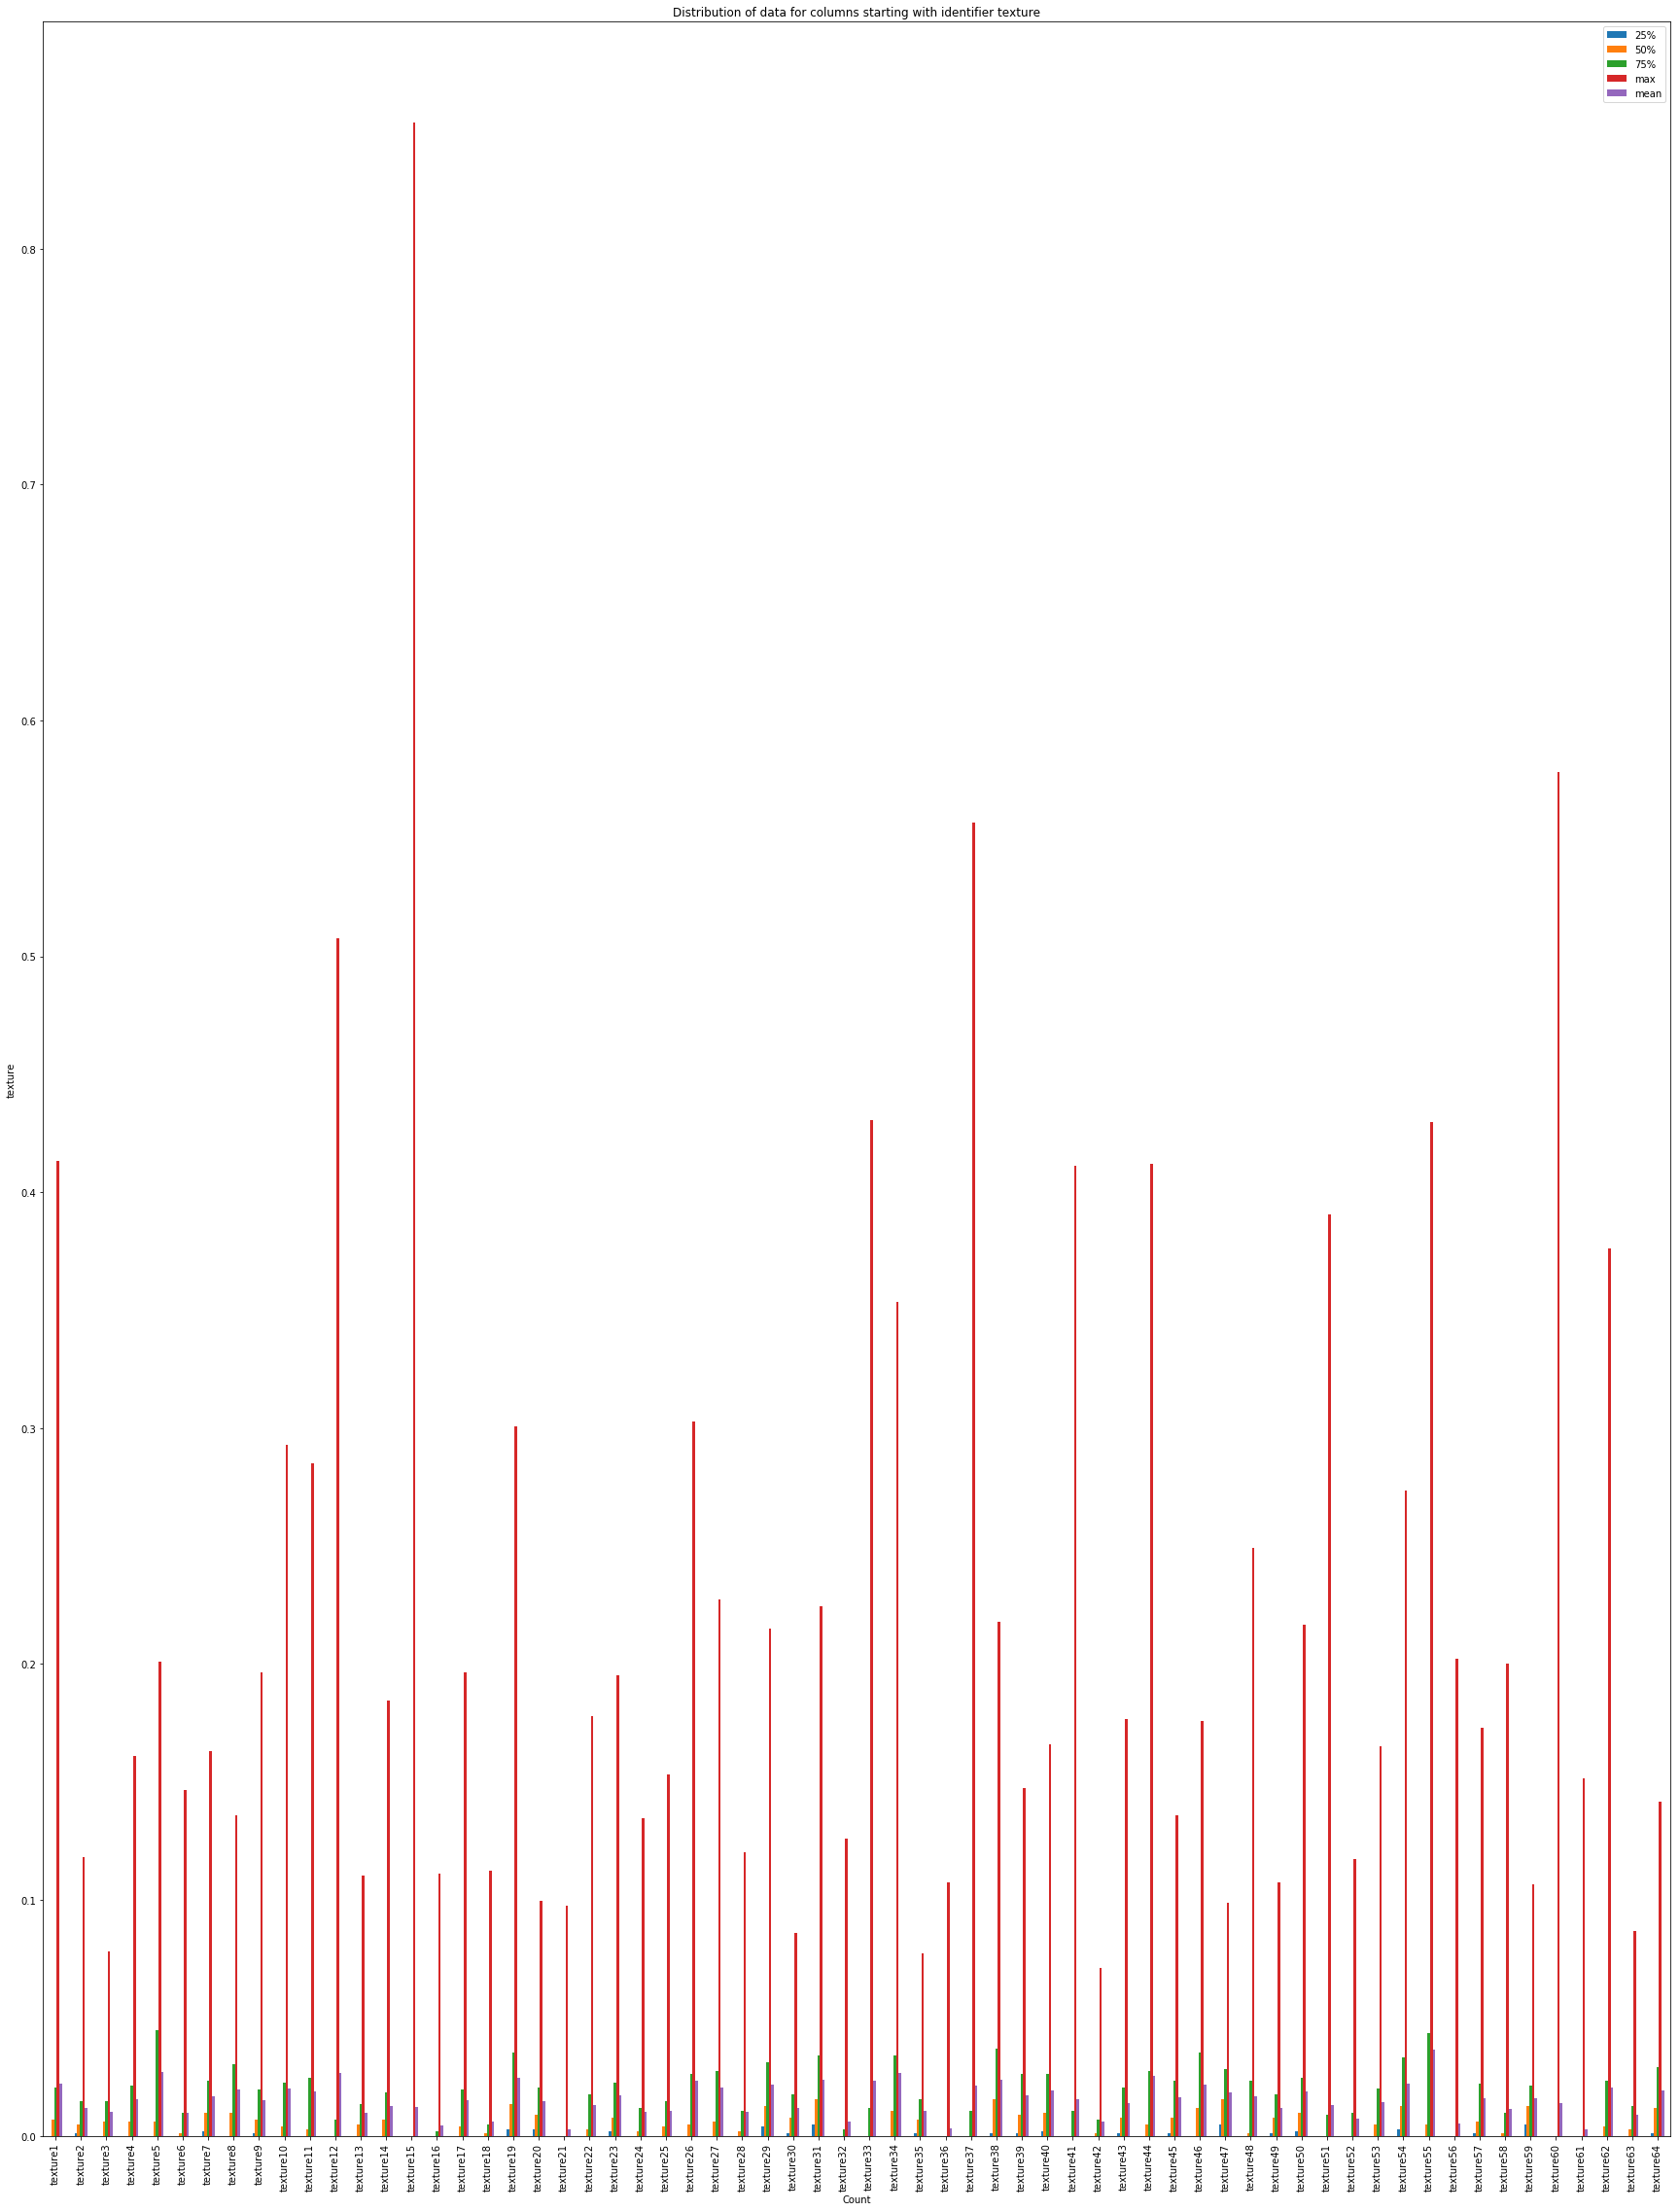

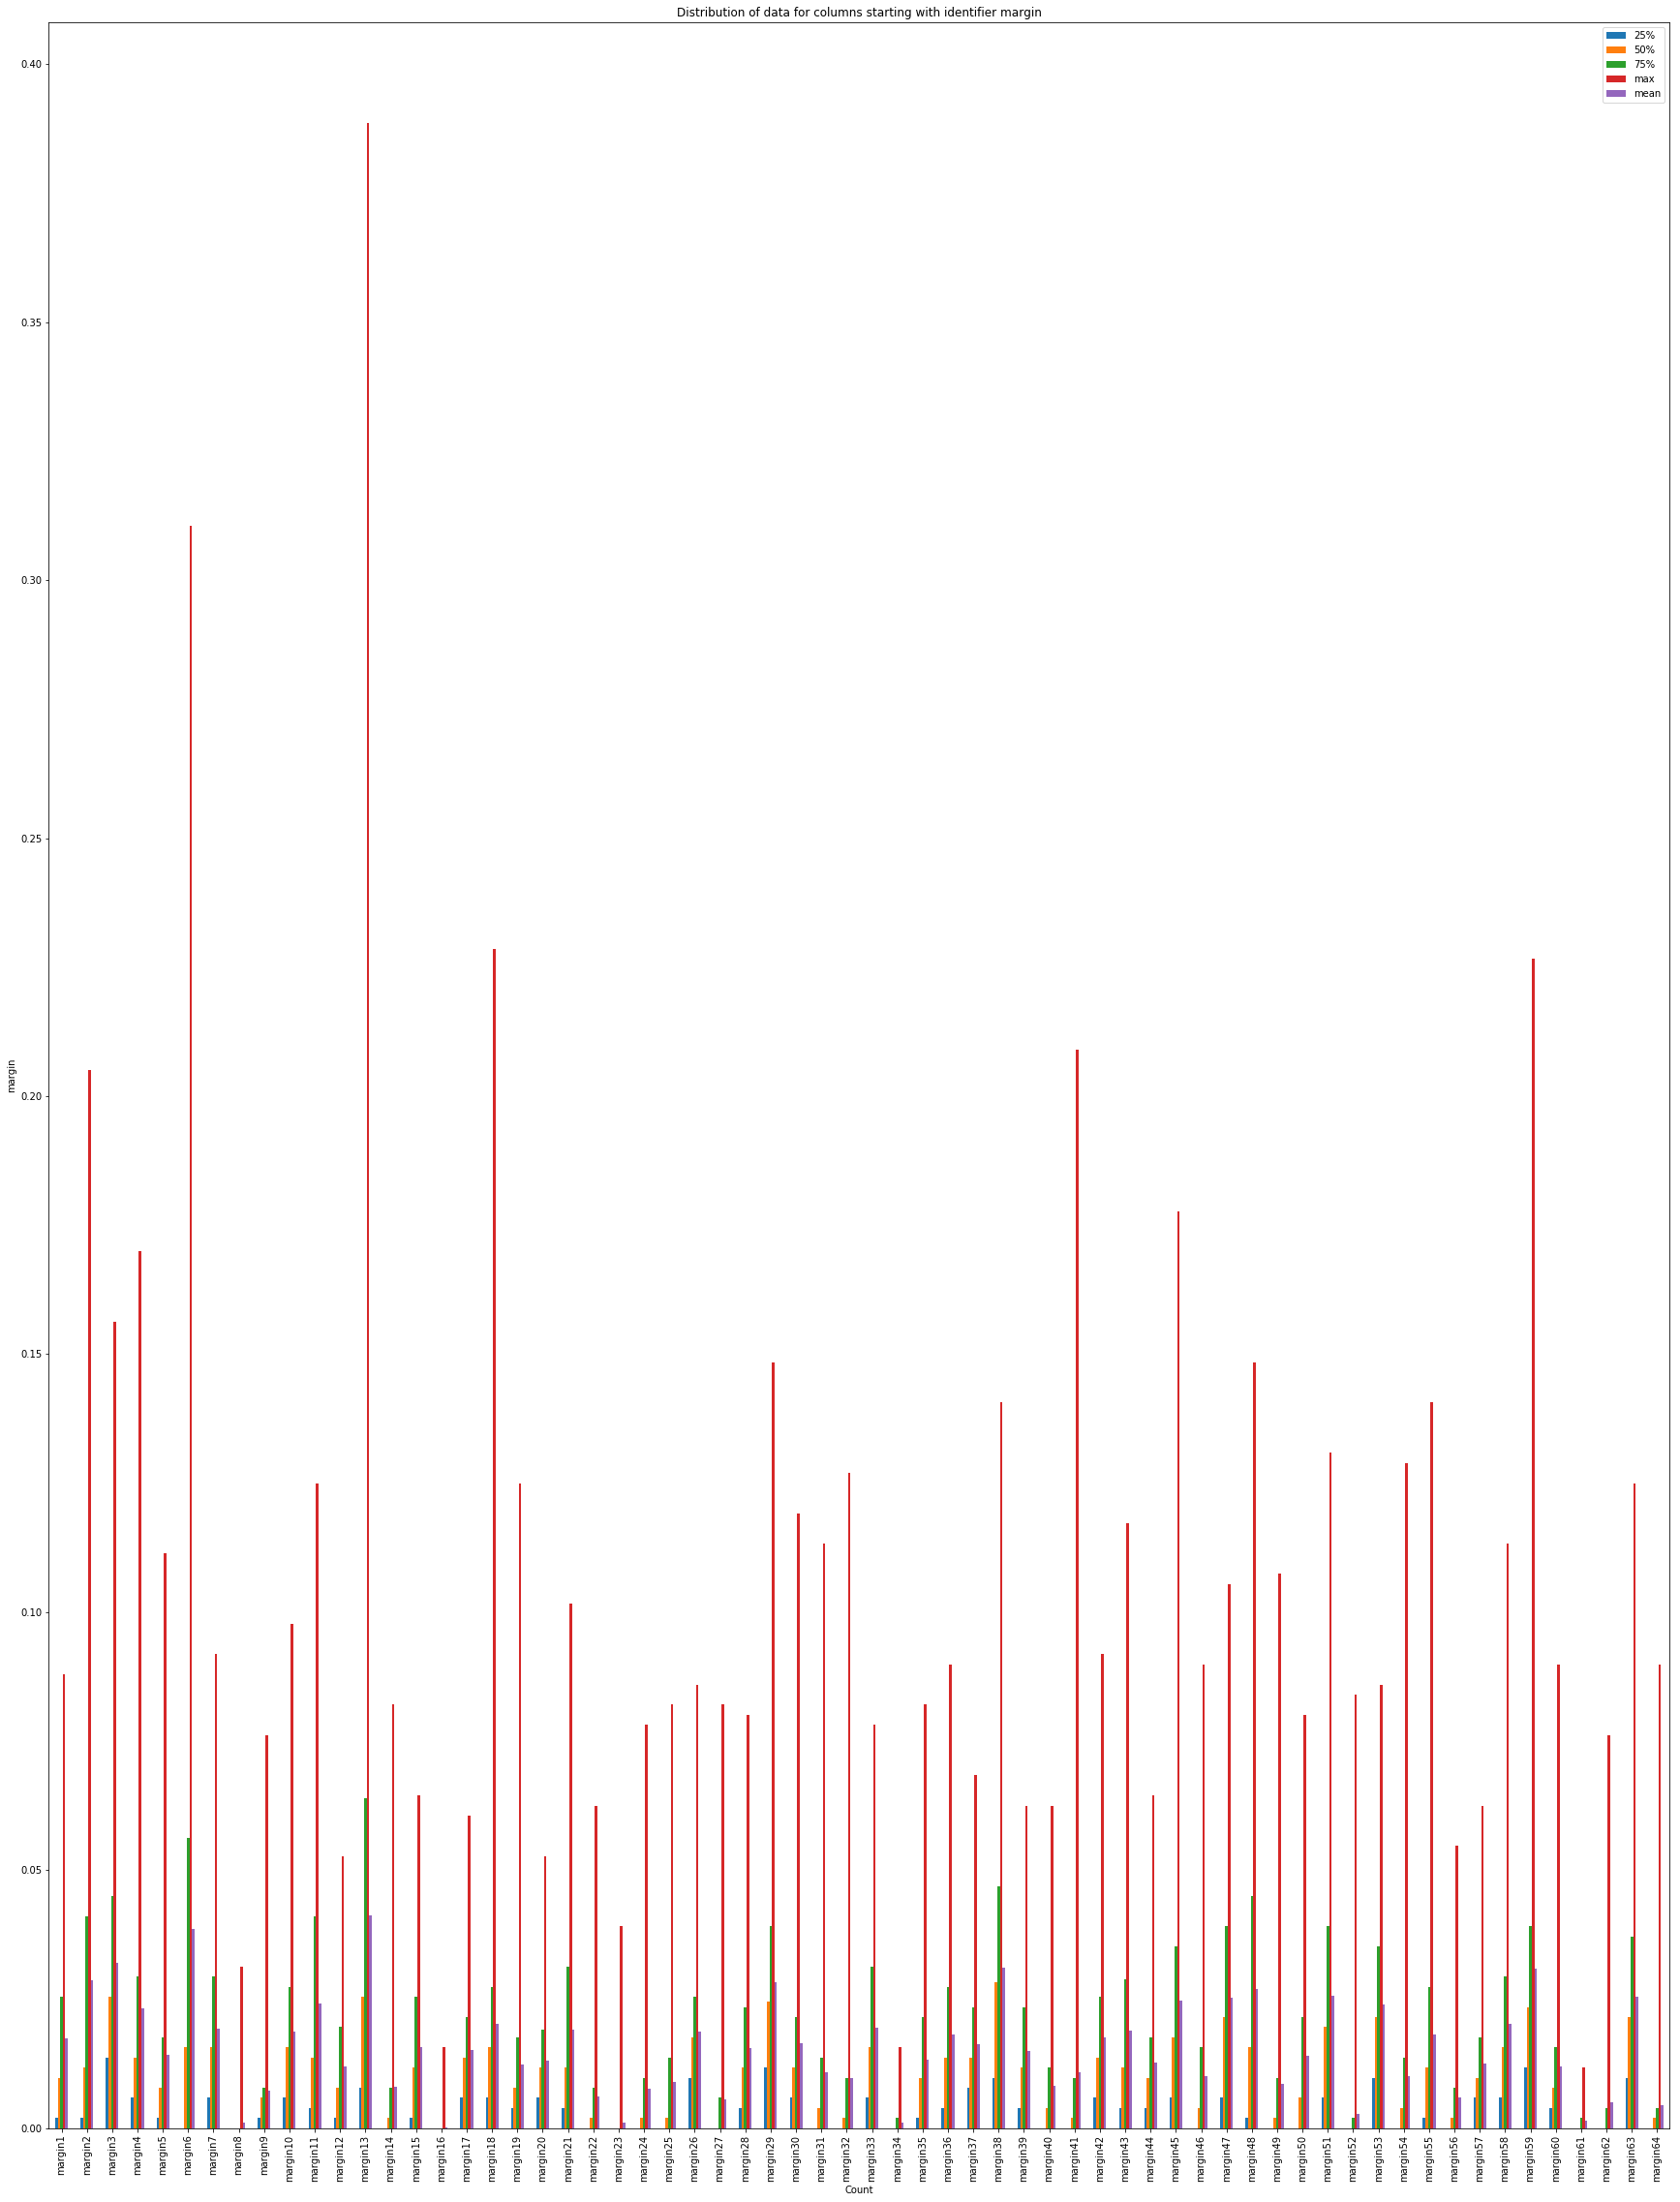

In [6]:

exclude_numbers = list(map(str, range(0,10)))
column_identifiers = map(lambda x:''.join([i for i in x if i not in exclude_numbers]), columns_wanted)
column_identifiers = set(column_identifiers)

## lets start plotting 25%, 50%, 75% and mean of the indivual column identifiers. we know from our data description that there are 64 of each

for col in column_identifiers:
    train_data_description.loc[[col + str(i) for i in range(1,65)]].plot(kind='bar', figsize = (30,40))
    plot.title("Distribution of data for columns starting with identifier " + col)
    plot.xlabel("Count")
    plot.ylabel(col)
    plot.show()






Based off our bar charts drawn above we can draw the following conclusions:
    
    1. Shape has good distribution of non zero data. Hence we are not going to touch columns starting with shape( for now )    
    
    2. Margin columns has a few "non conformers", where max appearances of 0 has been observed. These columns are margin8, margin16, margin23.    
    
    3. Texture columns which require further analysis are 56,61,36 and 23
    

In [7]:
print('value counts for column margin8 \n', train_data['margin8'].value_counts()\
          , '\n for column margin16 \n', train_data['margin16'].value_counts()\
          , '\n for column margin23 \n', train_data['margin23'].value_counts())

print('value counts for column texture23 \n', train_data['texture23'].value_counts()\
          , '\n for column texture36 \n', train_data['texture36'].value_counts()\
          , '\n for column texture56 \n', train_data['texture56'].value_counts() \
          , '\n for column texture61 \n', train_data['texture61'].value_counts())


value counts for column margin8 
 0.000000    805
0.005859     91
0.003906     50
0.007812     20
0.001953     16
0.013672      2
0.017578      2
0.015625      2
0.031250      2
Name: margin8, dtype: int64 
 for column margin16 
 0.000000    977
0.007812      4
0.005859      4
0.015625      2
0.009766      1
0.011719      1
0.001953      1
Name: margin16, dtype: int64 
 for column margin23 
 0.000000    909
0.005859     16
0.007812     11
0.001953      9
0.003906      8
0.015625      4
0.009766      4
0.013672      4
0.019531      4
0.025391      4
0.027344      3
0.011719      3
0.035156      2
0.023438      2
0.017578      2
0.021484      1
0.029297      1
0.033203      1
0.031250      1
0.039062      1
Name: margin23, dtype: int64
value counts for column texture23 
 0.000000    158
0.000977     64
0.001953     61
0.002930     49
0.003906     46
0.005859     45
0.004883     40
0.006836     29
0.011719     24
0.007812     21
0.010742     21
0.009766     20
0.008789     19
0.014648    

In [8]:
def calculateCorrelationCoefficientsAndpValues(x_data, y_data, xlabel):
    
    pearson_coef, p_value = stats.pearsonr(x_data, y_data)
    print("The Pearson Correlation Coefficient for %s is %s with a P-value of P = %s" %(xlabel,pearson_coef, p_value))
    
    return (pearson_coef,p_value)


def plotRegressionBetweenTwoVariables(x_label,y_label, x_y_data, pearson_coef, p_value):
    
    plot.figure(figsize=(15,15))
    
    sns.regplot(x = x_label , y = y_label , data = x_y_data)


    # plot.text(x = 1, y = 40000 , s ="Pearson Correlation Coefficient = %s"%pearson_coef, fontsize = 12 )
    # plot.text(x = 1, y = 38000 , s ="P value = %s"%p_value, fontsize = 12 )

    blue_patch = mpatches.Patch(color='blue', label='Pearson Correlation Coefficient = %s, p value is %s '%(pearson_coef, p_value))
    plot.legend(handles=[blue_patch], loc ='best')
    plot.title("Regression Plot %s vs %s"%(x_label, y_label))



Now we would simply start our modeling efforts using all other columns and estimate accuracy scores across model to select the best one



In [9]:
X = train_data[columns_wanted]
# Y = _y_train

_x_train, _x_test, _y_train, _y_test = train_test_split(X, Y, test_size =0.30, stratify = Y, random_state = 1)

##using COunter object we check to see if test and training has been properly distributed and we find it is.
print(Counter(Y))
print(Counter(_y_train))
print(Counter(_y_test))

Counter({3: 10, 49: 10, 65: 10, 94: 10, 84: 10, 40: 10, 54: 10, 78: 10, 53: 10, 89: 10, 98: 10, 16: 10, 74: 10, 50: 10, 58: 10, 31: 10, 43: 10, 4: 10, 75: 10, 44: 10, 83: 10, 13: 10, 66: 10, 15: 10, 6: 10, 73: 10, 22: 10, 36: 10, 27: 10, 88: 10, 12: 10, 28: 10, 21: 10, 25: 10, 20: 10, 60: 10, 69: 10, 23: 10, 76: 10, 18: 10, 52: 10, 9: 10, 48: 10, 47: 10, 64: 10, 81: 10, 62: 10, 34: 10, 92: 10, 79: 10, 82: 10, 32: 10, 35: 10, 72: 10, 71: 10, 11: 10, 51: 10, 5: 10, 8: 10, 37: 10, 97: 10, 33: 10, 1: 10, 59: 10, 56: 10, 57: 10, 29: 10, 93: 10, 10: 10, 46: 10, 0: 10, 39: 10, 2: 10, 24: 10, 26: 10, 87: 10, 55: 10, 38: 10, 45: 10, 7: 10, 67: 10, 30: 10, 61: 10, 96: 10, 41: 10, 85: 10, 14: 10, 17: 10, 42: 10, 63: 10, 86: 10, 80: 10, 77: 10, 19: 10, 95: 10, 70: 10, 90: 10, 68: 10, 91: 10})
Counter({28: 7, 55: 7, 13: 7, 64: 7, 66: 7, 95: 7, 56: 7, 46: 7, 41: 7, 22: 7, 89: 7, 37: 7, 69: 7, 70: 7, 5: 7, 14: 7, 10: 7, 26: 7, 72: 7, 23: 7, 7: 7, 44: 7, 86: 7, 90: 7, 16: 7, 25: 7, 35: 7, 96: 7, 17: 7



Now that our data has been separated out equally (70:30) between train and test data. Lets start our estimation algorithms across the following models:

1. LogisticRegression

2. SVM

3. DecisionTreeClassifier

4. RandomForestClassifier

5. KNearestNeighborClassifier



In [10]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [11]:
## cv is essentially value of K in k fold cross validation
    
## n_jobs = 1 is  non parallel execution    , -1 is all parallel , any other number say 2 means execute in 2 cpu cores

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()

In [12]:
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("F1 score %s" %f1_score(y_test,y_prediction, average = 'macro'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_, k_fold = 7)
                   
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
    response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average= 'macro')
    
    
    return response
    

In [14]:
classifiers = [
    
    LogisticRegression(random_state = 1),
    LogisticRegression(random_state = 1, solver = 'lbfgs', multi_class = 'multinomial'),
    DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
    RandomForestClassifier(random_state = 1, criterion = 'gini'),
    KNeighborsClassifier(metric = 'minkowski'),
    SVC(random_state = 1, kernel = 'rbf'), 
    LinearDiscriminantAnalysis()
     
]


classifier_names = [
            'logisticregression',
            'multinomiallogisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'svc', 
            'lda',
    
]

classifier_param_grid = [
            
            {'logisticregression__C':[100,200,300,50,20,600]},
            {'multinomiallogisticregression__C':[100,200,300,50,20,600], 'multinomiallogisticregression__penalty':['l2'], 'multinomiallogisticregression__max_iter':[100,200,300,400]},
            {'decisiontreeclassifier__max_depth':[1,2,4,6,7,8,9,10,11]},
            {'randomforestclassifier__n_estimators':[1,2,3,5,6]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,7,8]},
            {'svc__C':[1, 10, 100, 200], 'svc__gamma':[0.01 , 0.1, 0.05]},
            {'lda__n_components':[4,5,6]},
    
]


    

Grid Search Best parameters  {'logisticregression__C': 50}
Grid Search Best score  0.9696969696969697
Code block 'training' took(HH:MM:SS): 0:02:08.753103
Code block 'testing' took(HH:MM:SS): 0:00:00.001456
Accuracy score 0.9730639730639731
F1 score 0.9716450216450218
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         3
          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         3
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         3
         11       1.00      1.00      1.00         3
         12     

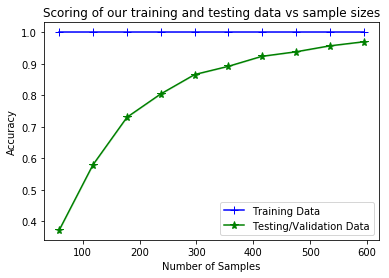

Code block 'learning_curve' took(HH:MM:SS): 0:01:36.882114
Grid Search Best parameters  {'multinomiallogisticregression__C': 100, 'multinomiallogisticregression__max_iter': 100, 'multinomiallogisticregression__penalty': 'l2'}
Grid Search Best score  0.9826839826839827
Code block 'training' took(HH:MM:SS): 0:01:41.461460
Code block 'testing' took(HH:MM:SS): 0:00:00.001554
Accuracy score 0.9865319865319865
F1 score 0.9861471861471861
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         3
          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         3
        

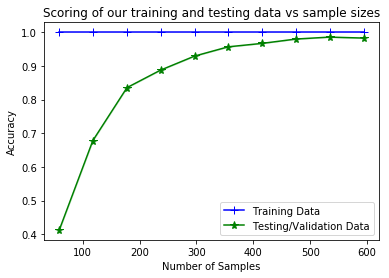

Code block 'learning_curve' took(HH:MM:SS): 0:00:19.648415
Grid Search Best parameters  {'decisiontreeclassifier__max_depth': 11}
Grid Search Best score  0.23665223665223664
Code block 'training' took(HH:MM:SS): 0:00:05.638332
Code block 'testing' took(HH:MM:SS): 0:00:00.001762
Accuracy score 0.2356902356902357
F1 score 0.2074088398539809
Classification report  
              precision    recall  f1-score   support

          0       0.75      1.00      0.86         3
          1       0.00      0.00      0.00         3
          2       0.08      1.00      0.14         3
          3       0.01      0.33      0.02         3
          4       1.00      1.00      1.00         3
          5       0.00      0.00      0.00         3
          6       0.43      1.00      0.60         3
          7       0.06      1.00      0.11         3
          8       0.00      0.00      0.00         3
          9       0.00      0.00      0.00         3
         10       0.00      0.00      0.00        

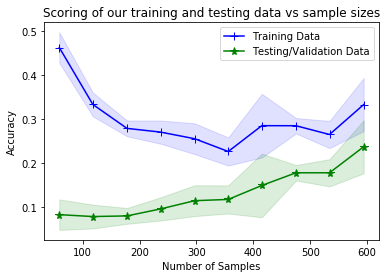

Code block 'learning_curve' took(HH:MM:SS): 0:00:05.461520
Grid Search Best parameters  {'randomforestclassifier__n_estimators': 6}
Grid Search Best score  0.7604617604617605
Code block 'training' took(HH:MM:SS): 0:00:01.615687
Code block 'testing' took(HH:MM:SS): 0:00:00.003209
Accuracy score 0.7878787878787878
F1 score 0.7767837101170434
Classification report  
              precision    recall  f1-score   support

          0       0.60      1.00      0.75         3
          1       1.00      1.00      1.00         3
          2       0.75      1.00      0.86         3
          3       0.50      0.67      0.57         3
          4       0.75      1.00      0.86         3
          5       0.75      1.00      0.86         3
          6       0.67      0.67      0.67         3
          7       0.50      0.67      0.57         3
          8       1.00      1.00      1.00         3
          9       1.00      0.67      0.80         3
         10       0.50      0.67      0.57       

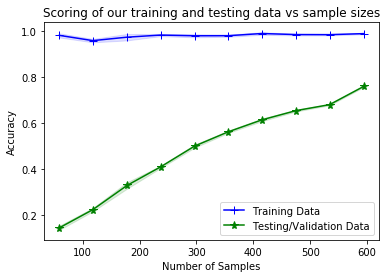

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.313398
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 4}
Grid Search Best score  0.9567099567099567
Code block 'training' took(HH:MM:SS): 0:00:04.112840
Code block 'testing' took(HH:MM:SS): 0:00:00.064735
Accuracy score 0.9461279461279462
F1 score 0.9417267917267917
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         3
          3       0.75      1.00      0.86         3
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         3
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         3

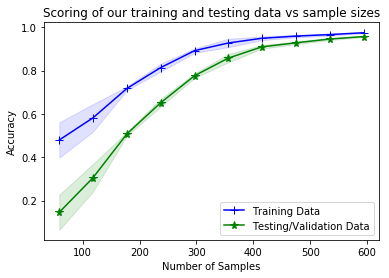

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.277372
Grid Search Best parameters  {'svc__C': 1, 'svc__gamma': 0.01}
Grid Search Best score  0.976911976911977
Code block 'training' took(HH:MM:SS): 0:00:33.591257
Code block 'testing' took(HH:MM:SS): 0:00:00.073243
Accuracy score 0.9764309764309764
F1 score 0.9761183261183259
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         3
          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         3
          9       1.00      0.67      0.80         3
         10       1.00      1.00      1.00         3
       

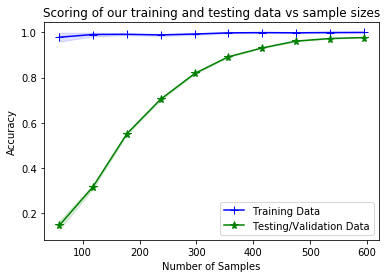

Code block 'learning_curve' took(HH:MM:SS): 0:00:12.688156
Grid Search Best parameters  {'lda__n_components': 4}
Grid Search Best score  0.9711399711399712
Code block 'training' took(HH:MM:SS): 0:00:00.610555
Code block 'testing' took(HH:MM:SS): 0:00:00.000782
Accuracy score 0.9730639730639731
F1 score 0.9712842712842713
Classification report  
              precision    recall  f1-score   support

          0       1.00      1.00      1.00         3
          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         3
          3       0.75      1.00      0.86         3
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         3
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         3
         11    

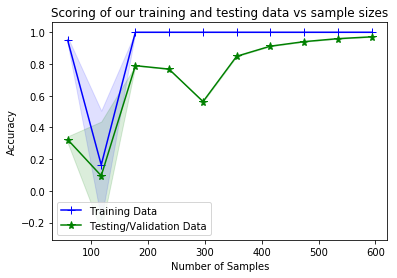

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.309939
Code block 'overalltime' took(HH:MM:SS): 0:06:59.550008
419550.00782221113


In [15]:

timer = CodeTimer(name='overalltime')
model_metrics = {}

with timer:
    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])

        result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid , cv = 7,score = 'accuracy')

        _y_prediction = result['_y_prediction']

        _matrix =  confusion_matrix(y_true = _y_test ,y_pred = _y_prediction)

        model_metrics[model_name] = {}
        model_metrics[model_name]['confusion_matrix'] = _matrix
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
        model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
        model_metrics[model_name]['f1_score'] = result['f1_score']
        model_metrics[model_name]['classes'] = encoder.inverse_transform(_y_prediction)
        
        
        
        
print(timer.took)




                              accuracy_score  \
logisticregression                  0.973064   
multinomiallogisticregression       0.986532   
decisiontreeclassifier               0.23569   
randomforestclassifier              0.787879   
kneighborsclassifier                0.946128   
svc                                 0.976431   
lda                                 0.973064   

                                                                         classes  \
logisticregression             [Cornus_Macrophylla, Magnolia_Salicifolia, Que...   
multinomiallogisticregression  [Cornus_Macrophylla, Magnolia_Salicifolia, Que...   
decisiontreeclassifier         [Cornus_Macrophylla, Acer_Mono, Quercus_Rubra,...   
randomforestclassifier         [Cornus_Macrophylla, Magnolia_Heptapeta, Querc...   
kneighborsclassifier           [Cornus_Macrophylla, Magnolia_Salicifolia, Que...   
svc                            [Cornus_Macrophylla, Magnolia_Salicifolia, Que...   
lda                        

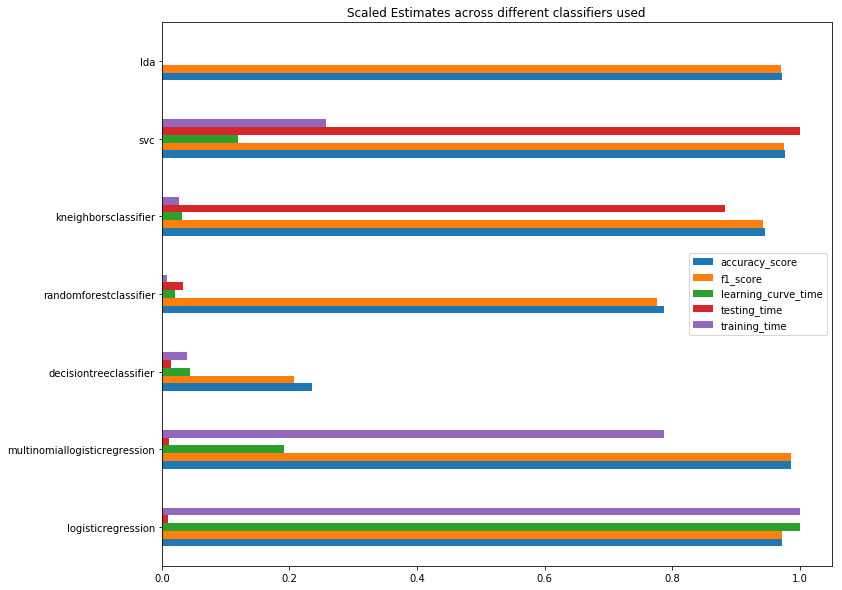

In [16]:

model_estimates = panda.DataFrame(model_metrics).transpose()


## convert model_metrics into panda data frame
## print out across model estimations and accuracy score bar chart


model_estimates['learning_curve_time'] = model_estimates['learning_curve_time'].astype('float64')
model_estimates['testing_time'] = model_estimates['testing_time'].astype('float64')
model_estimates['training_time'] = model_estimates['training_time'].astype('float64')
model_estimates['f1_score'] = model_estimates['f1_score'].astype('float64')

#scaling time parameters between 0 and 1
model_estimates['learning_curve_time'] = (model_estimates['learning_curve_time']- model_estimates['learning_curve_time'].min())/(model_estimates['learning_curve_time'].max()- model_estimates['learning_curve_time'].min())
model_estimates['testing_time'] = (model_estimates['testing_time']- model_estimates['testing_time'].min())/(model_estimates['testing_time'].max()- model_estimates['testing_time'].min())
model_estimates['training_time'] = (model_estimates['training_time']- model_estimates['training_time'].min())/(model_estimates['training_time'].max()- model_estimates['training_time'].min())

print(model_estimates)
model_estimates.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

We can see that our highest accuracy scores are from LinearDiscriminantAnalysis using the best parameters n_components = 4 with an accuracy of 97%. It also displays low variance at sample sizes greater than 600.


In [17]:

X_test = test_data[columns_wanted]
ids = test_data['id'].values



In [18]:
pipeline = Pipeline([('scaler', StandardScaler()),('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

param_grid = [{'lineardiscriminantanalysis__n_components':[4]}]

search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = 'accuracy', cv = 10)

search.fit(train_data[columns_wanted], train_data['species']) ## fit on the entire training data

probabilities = search.predict_proba(X_test)


classes = train_data['species'].values

# print(classes)

In [19]:

print(len(probabilities))
print(len(set(classes)))
print(len(ids))

594
99
594


In [20]:
submission = panda.DataFrame(probabilities, columns=set(classes))
submission.insert(0, 'id', ids)
submission.reset_index()

# Export Submission
submission.to_csv('C:/Users/somak/Documents/somak_python/real-world-use-cases/supervised/classification/kaggle/leaf_classification/submission.csv', index = False)
submission

,id,Tilia_Oliveri,Betula_Pendula,Quercus_Pyrenaica,Acer_Rufinerve,Quercus_Rubra,Quercus_Cerris,Cornus_Controversa,Quercus_Brantii,Zelkova_Serrata,...,Quercus_Variabilis,Quercus_Suber,Quercus_Crassifolia,Quercus_Ilex,Quercus_Texana,Quercus_Palustris,Ulmus_Bergmanniana,Quercus_Vulcanica,Castanea_Sativa,Fagus_Sylvatica
0,4,5.956416e-61,3.872117e-131,4.923615e-109,8.144226e-11,0.000000e+00,4.554510e-64,2.922527e-103,6.385992e-84,3.912086e-75,...,4.999369e-169,2.592082e-52,2.368761e-119,4.995059e-71,1.573088e-69,6.529121e-55,1.096112e-117,1.070795e-68,5.741916e-71,1.501994e-94
1,7,2.257212e-83,3.121396e-156,1.262776e-81,5.643123e-21,1.371230e-302,4.981996e-47,1.012007e-21,2.695623e-56,2.098105e-66,...,1.619139e-156,9.528604e-58,8.685023e-135,7.308119e-72,4.419783e-93,3.428585e-41,1.726366e-109,1.298508e-29,6.222686e-127,1.202071e-61
2,9,1.277739e-45,2.499793e-01,2.399643e-78,2.958381e-28,1.914517e-20,8.134587e-58,2.181108e-107,3.343140e-24,2.499792e-01,...,3.050014e-84,7.500435e-68,2.834429e-136,1.037462e-55,2.157511e-38,8.299597e-05,3.218959e-13,4.826533e-79,1.886576e-152,3.532384e-12
3,12,2.750659e-38,1.273511e-01,1.915568e-136,6.635473e-28,1.102980e-225,9.143356e-99,2.776479e-95,1.887768e-43,5.272737e-18,...,1.949714e-121,2.344711e-95,8.623375e-107,2.601438e-65,3.354449e-42,3.123151e-13,1.273511e-01,2.286721e-74,1.681890e-140,1.273511e-01
4,13,7.635792e-12,3.216445e-48,2.602859e-101,3.987252e-46,1.412902e-225,1.029456e-88,2.911238e-75,4.610281e-21,1.292192e-01,...,1.569808e-58,2.157716e-70,1.626904e-74,2.139496e-47,7.002616e-02,1.292192e-01,1.292192e-01,6.800048e-59,6.999778e-125,1.302169e-42
5,16,4.912403e-54,5.078936e-131,7.765106e-101,1.000000e+00,0.000000e+00,3.220183e-71,1.319955e-106,1.053102e-61,1.119335e-66,...,1.348487e-127,1.227428e-50,4.813520e-110,8.994937e-71,8.280342e-46,1.054881e-24,2.827002e-96,1.779168e-31,1.233828e-92,2.119932e-47
6,19,6.621342e-39,6.407825e-124,1.647929e-87,1.000000e+00,0.000000e+00,1.870498e-71,9.843610e-103,4.701416e-75,5.297387e-61,...,4.578088e-132,1.261228e-51,1.220271e-95,3.765939e-66,4.251946e-59,1.635595e-24,4.000883e-104,1.004829e-41,3.747709e-96,3.613568e-45
7,23,8.697707e-84,3.070906e-134,5.073978e-73,1.017161e-20,0.000000e+00,1.114433e-06,1.239196e-72,6.136670e-80,3.453590e-86,...,2.664995e-149,6.231461e-41,8.797101e-119,5.949030e-67,6.615418e-68,7.391995e-57,2.801421e-131,8.618750e-26,3.828135e-111,3.890829e-60
8,24,1.203272e-44,2.236997e-125,1.758021e-61,2.612401e-26,0.000000e+00,2.785643e-56,5.001837e-92,7.787192e-67,5.922792e-36,...,1.920743e-120,8.400290e-65,2.368540e-120,2.799936e-54,1.033843e-76,1.799572e-25,1.310871e-104,3.733607e-37,8.403959e-75,7.930156e-86
9,28,2.125209e-17,2.863909e-55,6.106555e-88,9.847149e-26,5.905032e-235,5.424318e-55,8.156727e-57,1.193811e-04,4.999403e-01,...,4.925663e-83,2.885450e-68,2.326678e-91,5.194437e-42,2.154297e-16,4.999403e-01,2.940351e-20,1.005332e-82,4.788968e-147,2.295893e-41
